In [1]:
import numpy as np
import scipy
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import colorcet as cc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# import sys
# sys.path.append('C:\Spring 2024\Research\Math_thesis\ActiveSet')
# from activeset import *

# In unit circle


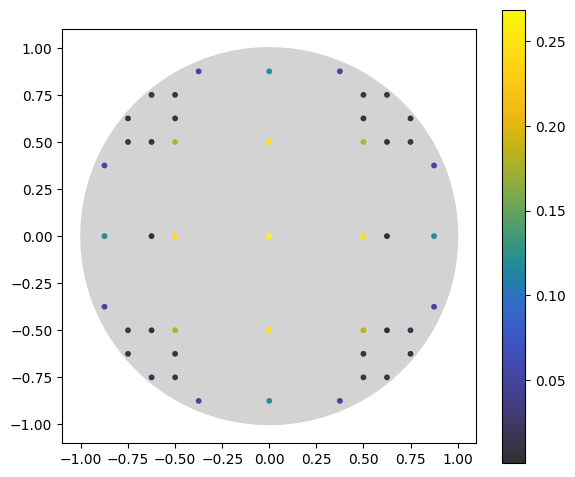

In [35]:
m = 10
M = 17

# Monomials and q(P^(j)) and its integral and partial derivatives 
def ps(n):
    p , q= [] , []
    px , py = [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            # Partial derivative w.r.t. x
            if i == 0:
                px.append(0)
            else:
                px.append((i-1,j))
            # Partial derivative w.r.t. y
            if j == 0:
                py.append(0)
            else:
                py.append((i,j-1))
            # Integral over unit disk
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(1/(a_i+a_j+2)*gamma(b_i)*gamma(b_j)*2/gamma(b_i+b_j))
    return p , np.array(q,dtype=float) , px , py
P , b_eq , Px , Py = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
legal = (sx**2 + sy**2 <=1)
sx = sx[legal].flatten()
sy = sy[legal].flatten()

# Sensitivity function
r = lambda x , y: x ** m + y ** m
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.gca().add_artist(plt.Circle((0, 0), 1, color='lightgray'))
plt.scatter(nonzero_x,nonzero_y , 10 , nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Convex combination

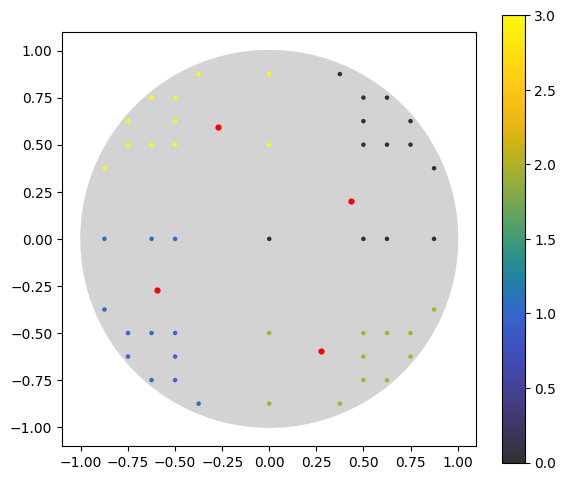

In [36]:
X = np.array([[nonzero_x[i] , nonzero_y[i]] for i in range(len(nonzero_x))])
score = float('-inf')
model = None
n_c = None
for n in range(2,len(nonzero_x)):
    kmeans = KMeans(n_clusters=n).fit(X)
    score_ = silhouette_score(X,kmeans.labels_)
    if score_ >= score:
        score = score_
        model = kmeans
        n_c = n

x_ = []
a_ = []
plt.figure(figsize=(6, 5))
plt.gca().add_artist(plt.Circle((0, 0), 1, color='lightgray'))
g_x , g_y , g_l = [] , [] , []
for label in range(n_c):
    group = model.labels_ == label
    ll = model.labels_[group]
    points = X[group]
    weights = nonzero_a[group]
    g_x.extend(points[:,0])
    g_y.extend(points[:,1])
    g_l.extend(ll)
    sum_w = weights.sum()
    x_.append((points.T@weights) / (sum_w))
    a_.append(sum_w)
x_ = np.array(x_)
a_ = np.array(a_)
plt.scatter(x_[:,0],x_[:,1],s=12,c='r')

plt.colorbar(plt.scatter(g_x , g_y  , s=5, c = g_l,cmap=cc.cm.gouldian  ))



plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [37]:
def Jacobian(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    J = np.zeros((len(P) , n))
    for i in range(len(P)):
        power1 , power2 , power3 = P[i] , Px[i] , Py[i]
        dx , dy = np.zeros(n//3) , np.zeros(n//3)
        p1 , p2 = power1
        dw = -x**p1*y**p2
        if power2 != 0:
            p1,p2 = power2
            dx = -w*(x**p1*y**p2)
        if power3 != 0:
            p1,p2 = power3
            dy = -w*(x**p1*y**p2)
        dr = np.concatenate([dx,dy,dw])
        J[i] = dr
    return J

def residual_f(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    r = np.zeros(len(P))
    for i in range(len(P)):
        p1 , p2 = P[i] 
        r[i] = b_eq[i] - np.dot(w , x**p1*y**p2)
    return r

def line_search(J,q,point):
    alpha = 1
    while (residual_f(point)**2).sum() - (residual_f(point + alpha*q)**2).sum() <= 1/2 * alpha * ((J@q)**2).sum():
        alpha *= 0.5
        if alpha <= 1e-10:
            break
    return alpha


x_x = x_[:,0]
x_y = x_[:,1]
initial = np.concatenate([x_x , x_y , a_])
point = initial.copy()
for i in range(100):
    R = residual_f(point)
    residual = (R**2).sum()
    if i%10 == 0:
        print(f'iter: {i} , residual:{residual}')
    if residual < 1e-15:
        print(f'Converge: iter: {i} , residual:{residual}')
        break
    J = Jacobian(point)
    # q = scipy.linalg.lstsq(J , -R)[0]
    
    mul = lambda x: J.T@(J@x)
    Jt_J = scipy.sparse.linalg.LinearOperator(
        shape=(len(point), len(point)), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
    q = scipy.sparse.linalg.cg(Jt_J, J.T@R, tol=min(1e-10, residual))[0]
    alpha = line_search(J , q , point)
    point += alpha * q


iter: 0 , residual:0.3538239840483992
iter: 10 , residual:0.3538239852919099
iter: 20 , residual:0.3538239865354205
iter: 30 , residual:0.3538239877789312
iter: 40 , residual:0.3538239890224417
iter: 50 , residual:0.3538239902659523
iter: 60 , residual:0.35382399150946287
iter: 70 , residual:0.35382399275297355
iter: 80 , residual:0.3538239939964842
iter: 90 , residual:0.3538239952399948


In [38]:
N = len(point)
qx , qy , qw = initial[:N//3] , initial[N//3:N*2//3] , initial[N*2//3:] 
res = 0


In [39]:
np.dot(qw , qx**2*qy**0)

0.5446407811080545

In [40]:
qw

array([0.98661681, 0.71824616, 0.71836484, 0.71836484])

In [41]:
N = len(point)
qx , qy , qw = point[:N//3] , point[N//3:N*2//3] , point[N*2//3:] 
res = 0
np.dot(qw , qx**2*qy**0),np.pi/4

(0.5446407812612901, 0.7853981633974483)

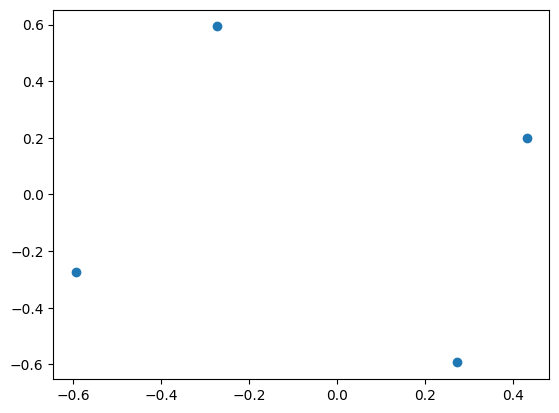

In [42]:
plt.scatter(qx,qy)

In [43]:
qw

array([0.98661679, 0.71824615, 0.71836487, 0.71836485])

# In squre

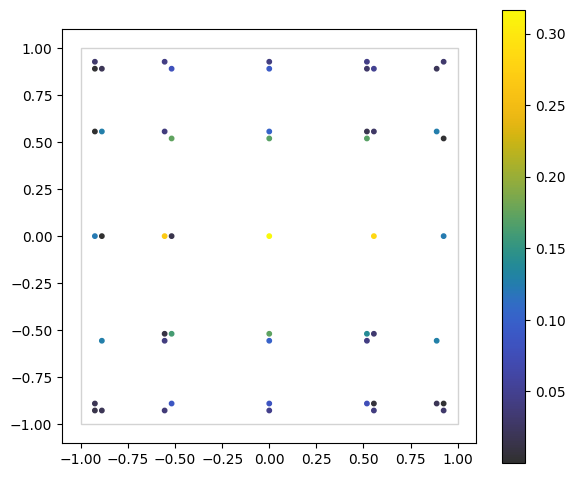

In [26]:
m = 10
M = 15
# Dirac measure
dirac = lambda X,x: int(x in X)

# Monomials and q(P^(j))
def ps(n):
    p , q= [] , []
    for i in range(n):
        for j in range(n-i):
            p.append((i , j))
            if j % 2 == 1 or i % 2 == 1:
                q.append(0)
            else:
                a_i , a_j = i , j
                b_i , b_j = (a_i + 1) / 2 , (a_j + 1) / 2
                q.append(4 / ((j + 1) * (i + 1)))
    return p , np.array(q,dtype=float)
P , b_eq = ps(m)

# Sample points with a small mesh size
_ = np.linspace(-1,1,M)
sx , sy = np.meshgrid(_ , _)
sx = sx.flatten()
sy = sy.flatten()

# Sensitivity function
r = lambda x , y: x ** (m) + y ** (m)
# Coefficients of \mu(r)
c = r(sx , sy)
# Equality constraint
A_eq = np.array([sx ** i * sy ** j for i,j in P])
alpha = scipy.optimize.linprog(c , A_eq=A_eq , b_eq=b_eq , bounds=(0,np.inf)).x
nozero = alpha != 0
nonzero_a = alpha[nozero]
nonzero_x , nonzero_y= sx[nozero] , sy[nozero]
plt.figure(figsize=(6, 5))
plt.scatter(nonzero_x,nonzero_y , 10, nonzero_a, cmap=cc.cm.gouldian,
zorder=1)
plt.gca().add_patch(Rectangle((-1,-1),2,2,linewidth=1,edgecolor='lightgray',facecolor='none'))

plt.colorbar()
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('s.png')
plt.show()


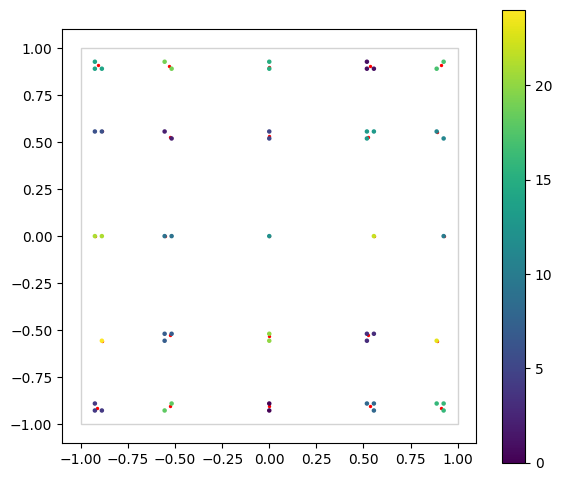

In [27]:
X = np.array([[nonzero_x[i] , nonzero_y[i]] for i in range(len(nonzero_x))])
score = float('-inf')
model = None
n_c = None
for n in range(2,len(nonzero_x)):
    kmeans = KMeans(n_clusters=n).fit(X)
    score_ = silhouette_score(X,kmeans.labels_)
    if score_ >= score:
        score = score_
        model = kmeans
        n_c = n

x_ = []
a_ = []
plt.figure(figsize=(6, 5))
plt.gca().add_patch(Rectangle((-1,-1),2,2,linewidth=1,edgecolor='lightgray',facecolor='none'))
g_x , g_y , g_l = [] , [] , []
for label in range(n_c):
    group = model.labels_ == label
    ll = model.labels_[group]
    points = X[group]
    weights = nonzero_a[group]
    g_x.extend(points[:,0])
    g_y.extend(points[:,1])
    g_l.extend(ll)
    sum_w = weights.sum()
    x_.append((points.T@weights) / (sum_w))
    a_.append(sum_w)
x_ = np.array(x_)
a_ = np.array(a_)
plt.scatter(x_[:,0],x_[:,1],s=2,c='r')
plt.colorbar(plt.scatter(g_x , g_y  , s= 5, c = g_l )
)


plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [31]:
def Jacobian(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    J = np.zeros((len(P) , n))
    for i in range(len(P)):
        power1 , power2 , power3 = P[i] , Px[i] , Py[i]
        dx , dy = np.zeros(n//3) , np.zeros(n//3)
        p1 , p2 = power1
        dw = -x**p1*y**p2
        if power2 != 0:
            p1,p2 = power2
            dx = -w*(x**p1*y**p2)
        if power3 != 0:
            p1,p2 = power3
            dy = -w*(x**p1*y**p2)
        dr = np.concatenate([dx,dy,dw])
        J[i] = dr
    return J

def residual_f(point):
    n = len(point)
    x , y , w = point[:n//3] , point[n//3:n*2//3] , point[n*2//3:] 
    r = np.zeros(len(P))
    for i in range(len(P)):
        p1 , p2 = P[i] 
        r[i] = b_eq[i] - np.dot(w , x**p1*y**p2)
    return r

def line_search(J,q,point):
    alpha = 1
    while (residual_f(point)**2).sum() - (residual_f(point + alpha*q)**2).sum() <= 1/2 * alpha * ((J@q)**2).sum():
        alpha *= 0.5
        if alpha <= 1e-10:
            break
    return alpha


x_x = x_[:,0]
x_y = x_[:,1]
initial = np.concatenate([x_x , x_y , a_])
point = initial.copy()
for i in range(100):
    R = residual_f(point)
    residual = (R**2).sum()
    if i%10 == 0:
        print(f'iter: {i} , residual:{residual}')
    if residual < 1e-15:
        print(f'Converge: iter: {i} , residual:{residual}')
        break
    J = Jacobian(point)
    q = scipy.linalg.lstsq(J , -R)[0]
    alpha = line_search(J , q , point)
    # mul = lambda x: J.T@(J@x)
    # Jt_J = scipy.sparse.linalg.LinearOperator(
    #     shape=(len(point), len(point)), matvec=mul, rmatvec=mul, matmat=mul, rmatmat=mul)
    # _ = scipy.sparse.linalg.cg(Jt_J, J.T@R, tol=min(1e-10, residual))[0]
    point += alpha * q



iter: 0 , residual:5.4642750196926244e-05
iter: 10 , residual:5.4642755442788426e-05
iter: 20 , residual:5.464276068865364e-05
iter: 30 , residual:5.464276593452003e-05
iter: 40 , residual:5.4642771180388106e-05
iter: 50 , residual:5.4642776426260595e-05
iter: 60 , residual:5.464278167213338e-05
iter: 70 , residual:5.4642786918007545e-05
iter: 80 , residual:5.464279216388319e-05
iter: 90 , residual:5.4642797409761814e-05


In [33]:
N = len(point)
qx , qy , qw = point[:N//3] , point[N//3:N*2//3] , point[N*2//3:] 
res = 0
np.dot(qw , qx**0*qy**0)

4.000000000000004

In [35]:
N = len(point)
qx , qy , qw = initial[:N//3] , initial[N//3:N*2//3] , initial[N*2//3:] 
res = 0
np.dot(qw , qx**0*qy**0)

4.000000000000002